# Implémentation de l'algorithme REINFORCE

L'implémentation proposé est inspiré par le tutoriel de [Gymnasium](https://gymnasium.farama.org/tutorials/training_agents/reinforce_invpend_gym_v26/)

Le pseudo code de l'algorithme est le suivant :


Entrée : politique différentiable $\pi(.|., \Theta)$ de, taux d'apprentissage $\alpha > 0$<br>
Sortie : politique optimal<br>
Pour chaque épisode :<br>
$\textrm{   }\textrm{   }\textrm{   }\textrm{   }$ Générer $S_{0}, A_{0}, R_{1}, ..., S_{T-1}, A_{T-1}, R_{T}$ en suivant la politique $\pi(.|., \theta)$ <br>
$\textrm{   }\textrm{   }\textrm{   }\textrm{   }$ Pour chaque étape de chaque épisode t = 0, 1, ..., T-1: <br>
$\textrm{   }\textrm{   }\textrm{   }\textrm{   }$ $\textrm{   }\textrm{   }\textrm{   }\textrm{   }$ $G := \sum^{T}_{k=t+1}\gamma^{k-t-1} R_{k}$<br>
$\textrm{   }\textrm{   }\textrm{   }\textrm{   }$ $\textrm{   }\textrm{   }\textrm{   }\textrm{   }$ $\theta := \theta + \alpha \gamma G \nabla \ln(\pi(A_{t}|S_{t}, \theta))$<br>
Retourner $\theta$


Avec :
* $S_{t}$ : état à l'instant $t$ <br>
* $A_{t}$ : action prise à l'instant $t$ <br>
* $R_{t}$ : récompense reçu à l'instant $t$ <br>

(pseudo-code venant de [wikipedia](https://fr.wikipedia.org/wiki/REINFORCE))

Dans ce cas, le *loss* n'est pas à minimiser comme dans la plupart des cas d'apprentissage profond, mais à maximiser. En effet, le but est de maximiser la somme des récompense (ici G)


## Import de librairie

In [1]:

import torch
import torch.nn as nn
from torch.distributions.normal import Normal
import gymnasium as gym
import matplotlib.pyplot as plt

## Définition du modèle de regression

In [2]:
class NormalDistribParam(nn.Module):
    def __init__(self, inChannel):
        super().__init__()
        self.inLayer = nn.Sequential(
            nn.Linear(inChannel, 32),
            nn.Tanh()
        )
        self.linLayer1 = nn.Sequential(
            nn.Linear(32, 32),
            nn.Tanh()
        )
        self.muLayer = nn.Sequential(
            nn.Linear(32, 1),
        )
        self.sigmaLayer = nn.Sequential(
            nn.Linear(32, 1),
        )
    def forward(self, x):
        x = self.inLayer(x.float())
        x = self.linLayer1(x)
        return self.muLayer(x),torch.log(1+torch.exp(self.sigmaLayer(x)))
    
    def save(self, path:str='model-reinforce/', env_name:str="InvertedPendulum-v4"):
        torch.save({"model":self.state_dict}, path+env_name+".pt")
        
    def load(self, path:str='model-reinforce/', env_name:str="InvertedPendulum-v4"):
        ckpt = torch.load(path+env_name+".pt")
        self.load_state_dict(ckpt["model"])
        

## Définition de la *policy* à optimiser

In [3]:
class Policy():
    def __init__(self, inChannel, lr) -> None:
        self.reg = NormalDistribParam(inChannel=inChannel)
        self.opti = torch.optim.AdamW(self.reg.parameters(), lr=lr)
        self.scheduler = torch.optim.lr_scheduler.ExponentialLR(self.opti, gamma=.9)
    def choose_action(self, state):
        
        mean, std = self.reg(torch.tensor(state))
        
        distrib = Normal(mean+1e-7, std+1e-7) # ajout d'une constante pour la stabilité 
        
        action = distrib.sample()
        p = distrib.log_prob(action)
        
        return action, p

In [4]:
def mean(liste:list)->list:
    return sum(liste)/len(liste)

In [5]:
def test_policy(env, policy, n):
    n_iter = 0
    r = 0
    for _ in range(n):
        term, trunc = False, False

        state, _ = env.reset()

        while (not term or trunc):
            action, _, _ = policy.choose_action(state)

            state, reward, term, trunc = env.step(action)

            n_iter += 1
            r += reward
    return n_iter/n, r/n

## Training loop pour Inverted Pendulum

In [38]:
nEpisode = 30000 
frequenceUpdate = 200 

gamma = .95

env_name = "InvertedPendulum-v4"

l_ps = []
l_rewards = []
avg_reward = []
ttlRewardEpisode = []
lenEpisode = []

In [39]:
env = gym.make(env_name)

policy = Policy(inChannel=env.observation_space.shape[0], lr=1e-3)

AVG nStep :  10.985
Episode : 200/30000 Average Reward : 0.7142857142857143
AVG nStep :  11.1
Episode : 400/30000 Average Reward : 0.7142857142857143
AVG nStep :  10.725
Episode : 600/30000 Average Reward : 0.8333333333333334
AVG nStep :  12.54
Episode : 800/30000 Average Reward : 0.92
AVG nStep :  11.835
Episode : 1000/30000 Average Reward : 0.7142857142857143
AVG nStep :  13.435
Episode : 1200/30000 Average Reward : 0.7777777777777778
AVG nStep :  13.15
Episode : 1400/30000 Average Reward : 0.7142857142857143
AVG nStep :  14.47
Episode : 1600/30000 Average Reward : 0.75
AVG nStep :  14.07
Episode : 1800/30000 Average Reward : 0.7142857142857143
AVG nStep :  15.11
Episode : 2000/30000 Average Reward : 0.75
AVG nStep :  17.02
Episode : 2200/30000 Average Reward : 0.8333333333333334
AVG nStep :  17.115
Episode : 2400/30000 Average Reward : 0.8461538461538461
AVG nStep :  17.36
Episode : 2600/30000 Average Reward : 0.8181818181818182
AVG nStep :  16.745
Episode : 2800/30000 Average Rewar

Text(0.5, 1.0, 'Length of each episode episode')

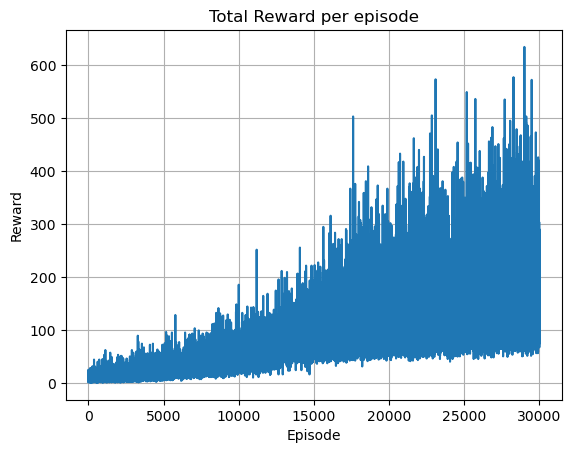

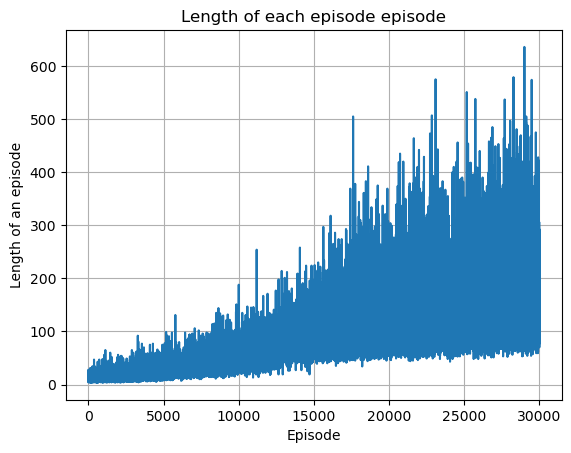

In [40]:
for episode in range(1, nEpisode+1):
    state, _ = env.reset()
    running = True
    l_reward = []
    l_p = []
    avg_rewards = []
    t = 0
    
    while running:
        
        action, p = policy.choose_action(state=state)
        state, r, terminated, truncated, _ = env.step(action=action)
        l_p.append(p)
        running = not (terminated or truncated)
        if running:
            l_reward.append(r)
            avg_reward.append(r)
        else:
            l_reward.append(-1)
            avg_reward.append(-1)
            
    l_ps.append(l_p)
    l_rewards.append(l_reward)
    avg_rewards.append(mean(l_reward))
    ttlRewardEpisode.append(sum(l_reward))
    lenEpisode.append(len(l_p))
    
    if episode % frequenceUpdate == 0:
        loss = 0
        policy.opti.zero_grad()
        
        print("AVG nStep : ", mean([len(l_ps[n]) for n in range(len(l_ps))]))
        for n in range(len(l_ps)):
            for t in range(len(l_ps[n])):
                loss += -1*l_ps[n][t]*torch.sum(torch.tensor([l_rewards[n][t]*gamma**(t_prime-t) for t_prime in range(t, len(l_ps[n]))]))

        loss.backward()
        policy.opti.step()
        
        if(episode%(frequenceUpdate*10)==0):
            policy.scheduler.step()
        print(f"Episode : {episode}/{nEpisode} Average Reward : {mean(avg_rewards)}")
        l_ps = []
        l_rewards = []
        avg_rewards = []

policy.reg.save(env_name=env_name)

plt.figure()
plt.plot(ttlRewardEpisode)
plt.grid()
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Total Reward per episode")

plt.figure()
plt.plot(lenEpisode)
plt.grid()
plt.xlabel("Episode")
plt.ylabel("Length of an episode")
plt.title("Length of each episode episode")        

## Training loop pour InvertedDoublePendulum

In [44]:
nEpisode = 30000 
frequenceUpdate = 200 

gamma = .95

env_name = "InvertedDoublePendulum-v4"

l_ps = []
l_rewards = []
avg_reward = []
ttlRewardEpisode = []
lenEpisode = []

In [45]:
env = gym.make(env_name)

policy = Policy(inChannel=env.observation_space.shape[0], lr=1e-3)

AVG nStep :  5.79
Episode : 200/30000 Average Reward : 9.048340627032884
AVG nStep :  5.89
Episode : 400/30000 Average Reward : 8.943678590288748
AVG nStep :  6.05
Episode : 600/30000 Average Reward : 8.964589364738055
AVG nStep :  6.31
Episode : 800/30000 Average Reward : 8.969967881681786
AVG nStep :  6.395
Episode : 1000/30000 Average Reward : 9.018227605718344
AVG nStep :  6.45
Episode : 1200/30000 Average Reward : 9.014678546654581
AVG nStep :  6.735
Episode : 1400/30000 Average Reward : 9.066255081192471
AVG nStep :  6.77
Episode : 1600/30000 Average Reward : 9.156281208287286
AVG nStep :  7.335
Episode : 1800/30000 Average Reward : 9.082570585166005
AVG nStep :  7.625
Episode : 2000/30000 Average Reward : 9.220543965951888
AVG nStep :  7.87
Episode : 2200/30000 Average Reward : 8.9938955760371
AVG nStep :  8.2
Episode : 2400/30000 Average Reward : 9.043082720417758
AVG nStep :  8.165
Episode : 2600/30000 Average Reward : 9.214718469824128
AVG nStep :  8.215
Episode : 2800/30000 

Text(0.5, 1.0, 'Length of each episode episode')

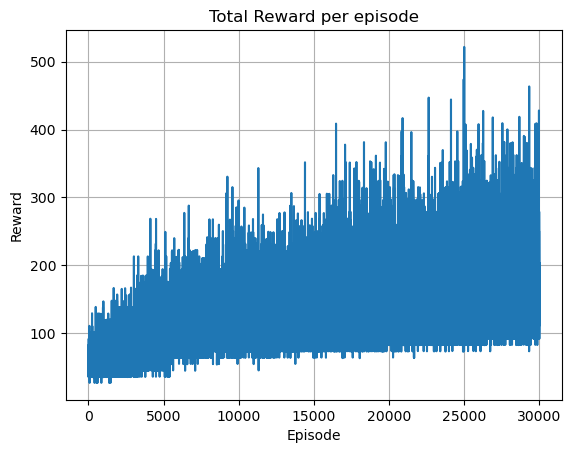

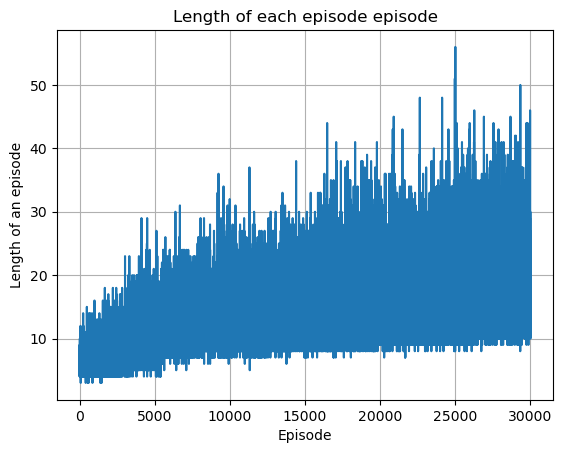

In [46]:
for episode in range(1, nEpisode+1):
    state, _ = env.reset()
    running = True
    l_reward = []
    l_p = []
    avg_rewards = []
    t = 0
    
    while running:
        
        action, p = policy.choose_action(state=state)
        state, r, terminated, truncated, _ = env.step(action=action)
        l_p.append(p)
        running = not (terminated or truncated)
        if running:
            l_reward.append(r)
            avg_reward.append(r)
        else:
            l_reward.append(r)
            avg_reward.append(r)
            
    l_ps.append(l_p)
    l_rewards.append(l_reward)
    avg_rewards.append(mean(l_reward))
    ttlRewardEpisode.append(sum(l_reward))
    lenEpisode.append(len(l_p))
    
    if episode % frequenceUpdate == 0:
        loss = 0
        policy.opti.zero_grad()
        
        print("AVG nStep : ", mean([len(l_ps[n]) for n in range(len(l_ps))]))
        for n in range(len(l_ps)):
            for t in range(len(l_ps[n])):
                loss += -1*l_ps[n][t]*torch.sum(torch.tensor([l_rewards[n][t]*gamma**(t_prime-t) for t_prime in range(t, len(l_ps[n]))]))

        loss.backward()
        policy.opti.step()
        
        if(episode%(frequenceUpdate*10)==0):
            policy.scheduler.step()
        print(f"Episode : {episode}/{nEpisode} Average Reward : {mean(avg_rewards)}")
        l_ps = []
        l_rewards = []
        avg_rewards = []

policy.reg.save(env_name=env_name)

plt.figure()
plt.plot(ttlRewardEpisode)
plt.grid()
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Total Reward per episode")

plt.figure()
plt.plot(lenEpisode)
plt.grid()
plt.xlabel("Episode")
plt.ylabel("Length of an episode")
plt.title("Length of each episode episode")        

# Conclusion

La taille moyenne des épisode augmente considérablement, même si les pendules ne reste pas à la verticale pour "toujour" (environ 1000 steps, le nombre maximal prévu par la librairie), le réseaux continue d'apprendre, il serait logique d'en déduire que en continuant l'apprentissage avec les mêmes paramètres les résultats ne seront que meilleurs. Cependant, plus la taille des épisodes augmente, plus le nombre de segment à échantillonner sera grand, plus l'apprentissage sera lent et couteux d'un point de vue calculatoire.